# Autoencoder and Dimension Reduction (2/2)

# Application to actual financial data

## References: 
* https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877
* https://github.com/sebastianheinz/stockprediction

* Predicting S&P 500 index based on 500 constituents prices 1 minute ago
* 500 stock price from April to August 2017 and S&P 500 index level

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

This dataset is already preprocessed - any missing data is filled with last observation and the SP500 index level is shifted forward by 1 minute. Therefore, each row represents SP500 level at t+1 while constituent stock prices at t

In [2]:
stock_data = pd.read_csv('./01_data/data_stocks.csv')
stock_data = stock_data.drop(['DATE'], 1) # Date is of no use - not a time series analysis

In [3]:
stock_data.head()

,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,38.99,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,39.01,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,38.91,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,38.84,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,38.93,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


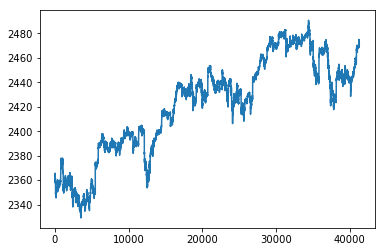

In [4]:
plt.plot(stock_data['SP500']);

In [5]:
n, p = stock_data.shape
stock_data = stock_data.values

In [6]:
# Split train vs test set - 80% train 20% test
# Do not worry about cross validation here
data_train = stock_data[:int(0.8*n),:]
data_test = stock_data[int(0.8*n):, :]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test) # important not to fit test set. 

In [9]:
# Build X and Y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [10]:
print(X_train.shape)
print(y_train.shape)

(33012, 500)
(33012,)


In [57]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [58]:
tf.reset_default_graph() 
tf.set_random_seed(100)

In [59]:
# Define graph parameters
n_inputs = 500 # 500 stocks
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256
n_hidden_4 = 128
n_output = 1 # output is the SP500 level - continuous function approximator

In [60]:
act_fn = tf.nn.relu # Define activation function. Reduce typing.. 

In [61]:
initializer = tf.variance_scaling_initializer(distribution='uniform')

In [62]:
# Layers
w1 = tf.Variable(initializer([n_inputs, n_hidden_1]), dtype=tf.float32)
w2 = tf.Variable(initializer([n_hidden_1, n_hidden_2]), dtype=tf.float32)
w3 = tf.Variable(initializer([n_hidden_2, n_hidden_3]), dtype=tf.float32)
w4 = tf.Variable(initializer([n_hidden_3, n_hidden_4]), dtype=tf.float32)
w_out = tf.Variable(initializer([n_hidden_4, n_output]), dtype=tf.float32)

# Biases
b1 = tf.Variable(tf.zeros(n_hidden_1))
b2 = tf.Variable(tf.zeros(n_hidden_2))
b3 = tf.Variable(tf.zeros(n_hidden_3))
b4 = tf.Variable(tf.zeros(n_hidden_4))
b_out = tf.Variable(tf.zeros(n_output))

In [63]:
# Construction
X = tf.placeholder(tf.float32, shape = [None, n_inputs]) # batch input
hidden_1 = act_fn(tf.matmul(X, w1) + b1)
hidden_2 = act_fn(tf.matmul(hidden_1, w2) + b2)
hidden_3 = act_fn(tf.matmul(hidden_2, w3) + b3)
hidden_4= act_fn(tf.matmul(hidden_3, w4) + b4)
output_layer = tf.transpose(tf.matmul(hidden_4, w_out) + b_out)

y_true = tf.placeholder(tf.float32, shape = [None]) # true answer

In [64]:
# Cost function
loss = tf.reduce_mean(tf.square(output_layer - y_true))

# Optimizer
optimizer = tf.train.AdamOptimizer() 
train = optimizer.minimize(loss)

In [65]:
init = tf.global_variables_initializer()

Loss train:  0.0014592727
Loss test:  0.023764202
Loss train:  0.00020885511
Loss test:  0.01658501
Loss train:  0.00016654807
Loss test:  0.014112269
Loss train:  0.00038399335
Loss test:  0.012095666
Loss train:  0.00022362894
Loss test:  0.010676086
Loss train:  8.477035e-05
Loss test:  0.010534234
Loss train:  0.00010178414
Loss test:  0.010430139
Loss train:  9.232149e-05
Loss test:  0.009316305
Loss train:  6.6387125e-05
Loss test:  0.00880925
Loss train:  0.00010456639
Loss test:  0.008734338


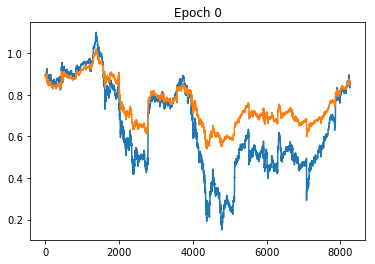

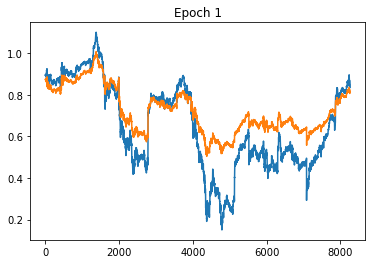

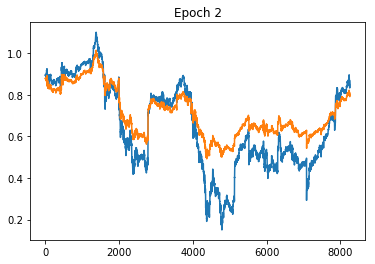

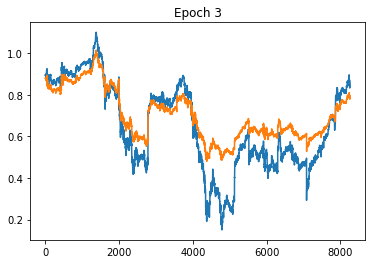

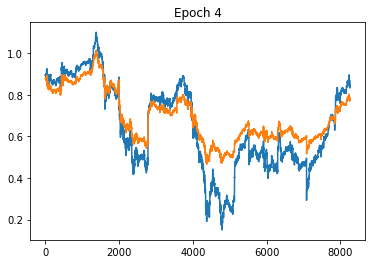

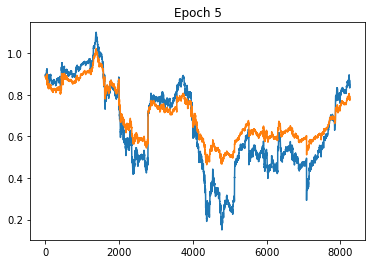

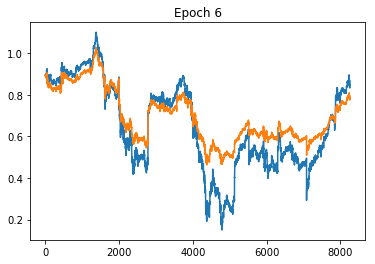

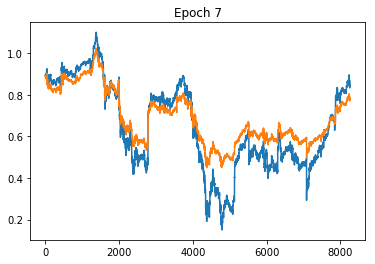

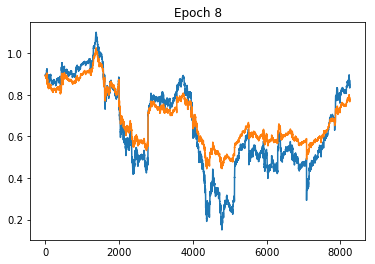

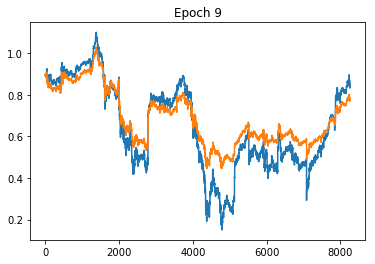

In [66]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train = []
loss_test = []

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train.append(sess.run(loss, feed_dict={X: X_train, y_true: y_train}))
        loss_test.append(sess.run(loss, feed_dict={X: X_test, y_true: y_test}))
        print('Loss train: ', loss_train[-1])
        print('Loss test: ', loss_test[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_test})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_test)
        line2, = ax1.plot(y_test)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)

In [72]:
loss_test

[0.023764202,
 0.01658501,
 0.014112269,
 0.012095666,
 0.010676086,
 0.010534234,
 0.010430139,
 0.009316305,
 0.00880925,
 0.008734338]

## Apply autoencoder and train

In [68]:
# Define autoencoder layers
n_auto = 100 # 1/5 reduction
auto_layer = fully_connected(X, n_auto, activation_fn=tf.nn.elu, 
                             weights_initializer=tf.variance_scaling_initializer, 
                             biases_initializer=tf.zeros_initializer)
auto_output = fully_connected(auto_layer, n_inputs, activation_fn=None,
                              weights_initializer=tf.variance_scaling_initializer, 
                              biases_initializer=tf.zeros_initializer)

loss_auto = tf.reduce_mean(tf.square(auto_output - X))
train_auto = tf.train.AdamOptimizer().minimize(loss_auto)

In [69]:
init = tf.global_variables_initializer()

In [70]:
# Auto encoder training
num_epochs = 100
num_batches = 1024

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):

        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train[shuffle_indices]
        y_train_e = y_train[shuffle_indices]

        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            sess.run(train_auto, feed_dict={X: x_batch})
        
        # see filtering results
        if e % 10 == 0: 
            loss_eval = sess.run(loss_auto, feed_dict={X: X_train})
            print('epoch {}: loss is {}'.format(e, loss_eval))
            
    # Later usage
    X_train_auto = auto_output.eval(feed_dict={X: X_train})
    X_test_auto = auto_output.eval(feed_dict={X: X_test})

epoch 0: loss is 0.05946488305926323
epoch 10: loss is 0.006997536402195692
epoch 20: loss is 0.004059447906911373
epoch 30: loss is 0.00286175892688334
epoch 40: loss is 0.0022074547596275806
epoch 50: loss is 0.002011778997257352
epoch 60: loss is 0.0015086146304383874
epoch 70: loss is 0.0013192277401685715
epoch 80: loss is 0.0011692860862240195
epoch 90: loss is 0.0011733685387298465


Apply index prediction training

Loss train:  0.0008855649
Loss test:  0.023142084
Loss train:  0.00019474713
Loss test:  0.010996111
Loss train:  0.00013290271
Loss test:  0.008006339
Loss train:  0.00021162762
Loss test:  0.0070256847
Loss train:  0.00010929545
Loss test:  0.006164677
Loss train:  0.00010840836
Loss test:  0.005545266
Loss train:  0.0024795316
Loss test:  0.007826354
Loss train:  0.00013306945
Loss test:  0.0042939316
Loss train:  8.5651154e-05
Loss test:  0.003762643
Loss train:  8.509878e-05
Loss test:  0.0035522915


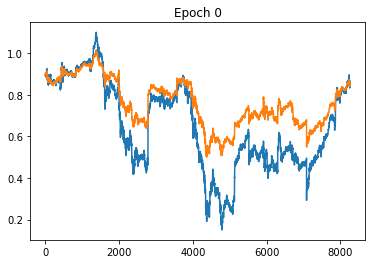

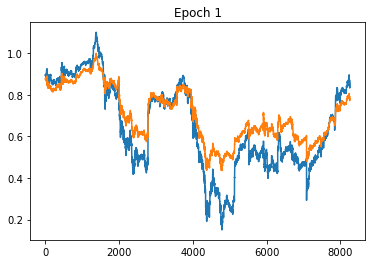

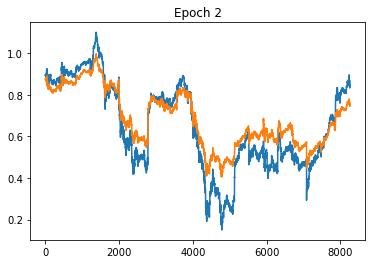

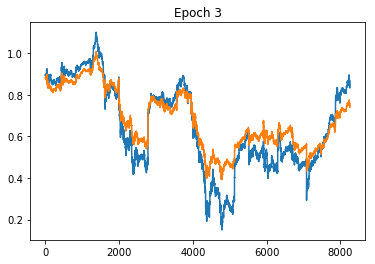

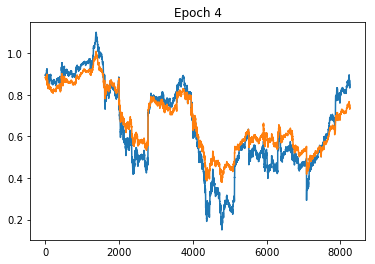

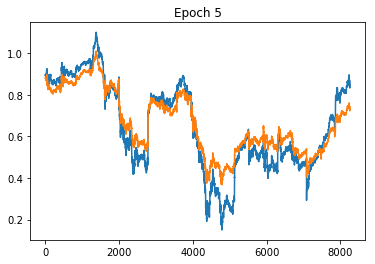

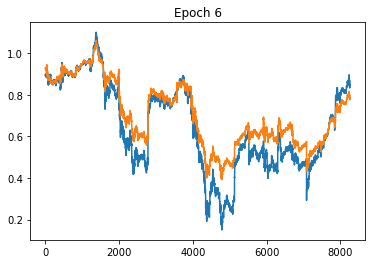

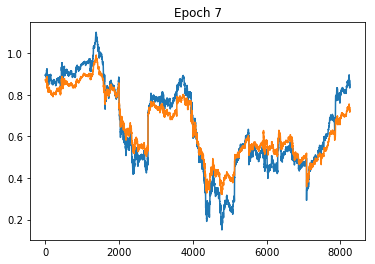

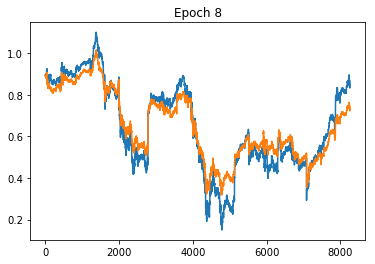

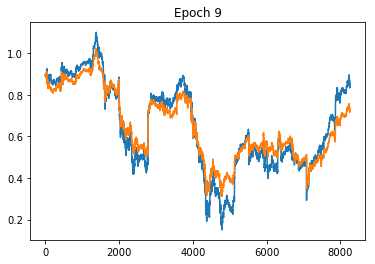

In [71]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train_auto = []
loss_test_auto = []

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train_auto[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train_auto.append(sess.run(loss, feed_dict={X: X_train_auto, y_true: y_train}))
        loss_test_auto.append(sess.run(loss, feed_dict={X: X_test_auto, y_true: y_test}))
        print('Loss train: ', loss_train_auto[-1])
        print('Loss test: ', loss_test_auto[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_test_auto})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_test)
        line2, = ax1.plot(y_test)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)

## PCA on the same setup

In [73]:
from sklearn.decomposition import PCA

In [74]:
train_pca = PCA(n_components=100).fit(X_train) # Do PCA
X_train_pca = train_pca.inverse_transform(train_pca.transform(X_train))
X_test_pca = train_pca.inverse_transform(train_pca.transform(X_test))

Loss train:  0.0015091
Loss test:  0.039852366
Loss train:  0.00019814043
Loss test:  0.021080976
Loss train:  0.0021508737
Loss test:  0.018697605
Loss train:  0.0001739961
Loss test:  0.016412212
Loss train:  0.00010207456
Loss test:  0.014827094
Loss train:  8.568794e-05
Loss test:  0.013716979
Loss train:  0.00013608504
Loss test:  0.012244678
Loss train:  7.3801195e-05
Loss test:  0.011195751
Loss train:  0.00011768563
Loss test:  0.010765315
Loss train:  6.790414e-05
Loss test:  0.009116161


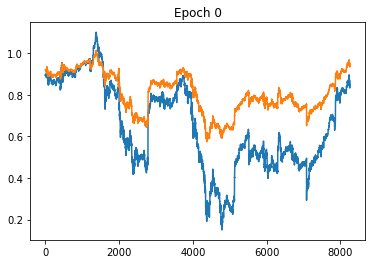

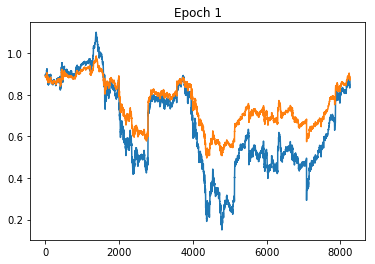

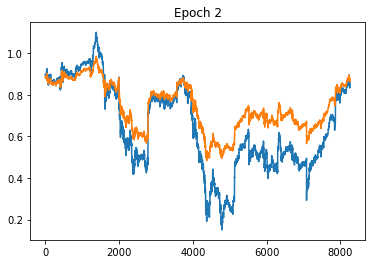

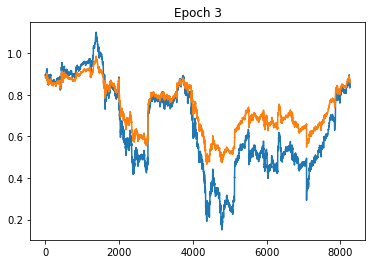

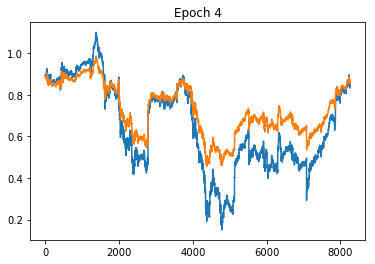

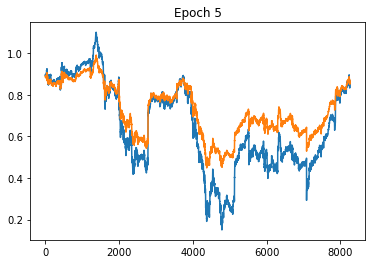

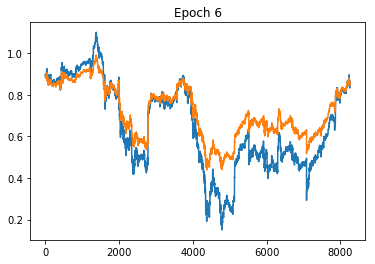

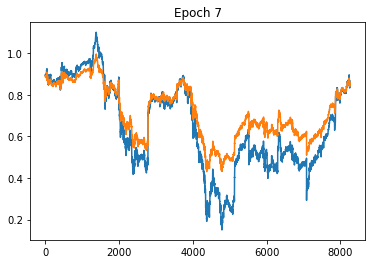

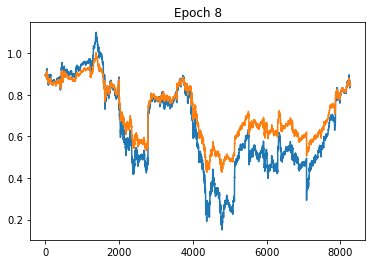

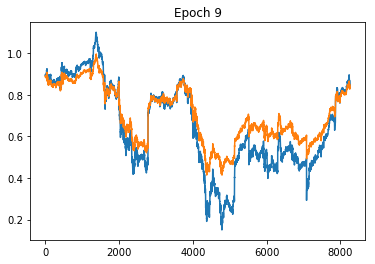

In [75]:
# actual train
num_epochs = 10
batch_size = 1024
loss_train_pca = []
loss_test_pca = []

with tf.Session() as sess:
    tf.set_random_seed(100)
    sess.run(init)
    
    for e in range(num_epochs):
        
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(np.arange(len(y_train)))
        X_train_e = X_train_pca[shuffle_indices]
        y_train_e = y_train[shuffle_indices]
        
        # Minibatch training
        num_batches = len(y_train) // batch_size
        for iteration in range(num_batches):
            start = iteration * batch_size
            x_batch = X_train_e[start:(start + batch_size)]
            y_batch = y_train_e[start:(start + batch_size)]
            sess.run(train, feed_dict={X: x_batch, y_true: y_batch})
            
        # Monitor training at each epoch
        loss_train_pca.append(sess.run(loss, feed_dict={X: X_train_pca, y_true: y_train}))
        loss_test_pca.append(sess.run(loss, feed_dict={X: X_test_pca, y_true: y_test}))
        print('Loss train: ', loss_train_pca[-1])
        print('Loss test: ', loss_test_pca[-1])
        # Prediction
        pred = sess.run(output_layer, feed_dict={X: X_test_pca})

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        line1, = ax1.plot(y_test)
        line2, = ax1.plot(y_test)
        line2.set_ydata(pred)
        plt.title('Epoch ' + str(e))
        plt.pause(0.01)

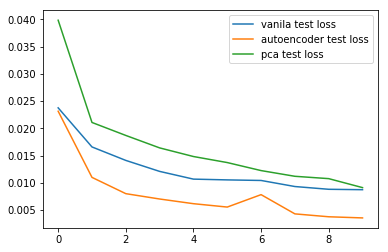

In [76]:
plt.plot(np.arange(num_epochs), loss_test, label='vanila test loss')
plt.plot(np.arange(num_epochs), loss_test_auto, label='autoencoder test loss')
plt.plot(np.arange(num_epochs), loss_test_pca, label='pca test loss')
plt.legend();